In [5]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def threshold_function(right_elbow_y):
    """
    Detect gesture start and end based on a threshold.
    For this example, frames where the right elbow Y-coordinate is lower
    than (mean - std) are considered part of the gesture.
    
    Parameters:
        right_elbow_y (np.ndarray): 1D array of right elbow Y-coordinates.
    
    Returns:
        list: Indices of frames considered to contain the gesture.
    """
    mean_value = np.mean(right_elbow_y)
    std_dev = np.std(right_elbow_y)
    threshold = mean_value - std_dev  # Suggested threshold

    gesture_start = None
    gesture_end = None
    gesture_frames = []

    for i, y in enumerate(right_elbow_y):
        if y <= threshold:
            if gesture_start is None:
                gesture_start = i
            gesture_frames.append(i)
        elif gesture_start is not None:
            # Once a gesture has started, if the current frame doesn't satisfy
            # and no future frame will, we break.
            future_satisfies = any(right_elbow_y[j] <= threshold for j in range(i+1, len(right_elbow_y)))
            if not future_satisfies:
                gesture_end = i - 1
                break

    if gesture_start is None:
        # No gesture detected
        return []
    if gesture_end is None:
        gesture_end = len(right_elbow_y) - 1

    return list(range(gesture_start, gesture_end + 1))

def filter_frames_with_threshold(pkl_file_path, output_pkl_path, threshold_function, visualize=False):
    """
    Filter frames from a PKL dataset based on pose keypoints (using the right elbow's Y-coordinate).
    
    Parameters:
        pkl_file_path (str): Path to the input PKL file.
        output_pkl_path (str): Path to save the filtered PKL file.
        threshold_function (function): Function that returns a list of frame indices based on a threshold.
        visualize (bool): If True, display a plot of the threshold detection.
    """
    # Load the PKL file
    with open(pkl_file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Extract the pose data.
    # We assume that the pose data is a NumPy array with shape (frames, keypoints, 3)
    # and that the right elbow is at index 3 (thus we use its Y-coordinate: index 1).
    pose_data = data['pose']
    right_elbow_y = pose_data[:, 3, 1]  # right elbow y-coordinate for all frames

    # Get the indices of frames where the gesture is detected.
    gesture_frames = threshold_function(right_elbow_y)

    if not gesture_frames:
        print(f"No gesture frames detected in {pkl_file_path}. Skipping filtering.")
        return

    # Filter every key (pose, hand_left, hand_right) by the detected frame indices.
    filtered_data = {key: value[gesture_frames] for key, value in data.items()}

    # Save the filtered data to a new PKL file.
    with open(output_pkl_path, 'wb') as f:
        pickle.dump(filtered_data, f)
    
    print(f"Filtered dataset saved to: {output_pkl_path}")

    if visualize:
        plt.figure(figsize=(10, 6))
        plt.plot(right_elbow_y, label="Right Elbow Y-coordinate")
        threshold_line = np.mean(right_elbow_y) - np.std(right_elbow_y)
        plt.axhline(threshold_line, color="red", linestyle="--", label="Threshold")
        plt.scatter(gesture_frames, right_elbow_y[gesture_frames], color="green",
                    label="Gesture Frames", zorder=5)
        plt.title("Gesture Detection Based on Pose (Right Elbow)")
        plt.xlabel("Frame Number")
        plt.ylabel("Y-coordinate")
        plt.legend()
        plt.show()

def process_all_pkl_files_with_threshold(input_dir, output_dir, threshold_function, visualize=False):
    """
    Process all PKL files in the input directory, apply frame filtering based on the pose data,
    and save the filtered PKL files in the output directory.
    
    Parameters:
        input_dir (str): Directory containing the original PKL files.
        output_dir (str): Directory where the filtered PKL files will be saved.
        threshold_function (function): Function to compute frame indices from the pose data.
        visualize (bool): If True, visualize the detection for each file.
    """
    os.makedirs(output_dir, exist_ok=True)
    pkl_files = [f for f in os.listdir(input_dir) if f.endswith('.pkl')]
    
    for pkl_file in pkl_files:
        input_path = os.path.join(input_dir, pkl_file)
        output_path = os.path.join(output_dir, pkl_file)
        print(f"Processing {input_path}...")
        filter_frames_with_threshold(input_path, output_path, threshold_function, visualize)

# === Example usage ===

# Set the directory where your unfiltered PKL files are stored.
input_dir = r"/nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01"

# Set the directory where you want the filtered PKL files to be saved.
output_dir = r"/nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01_threshold/"

# Process all files. Set visualize=True if you want to see a plot for each file.
process_all_pkl_files_with_threshold(input_dir, output_dir, threshold_function, visualize=False)


Processing /nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01/NIA_SL_WORD1417_REAL01_U.pkl...
Filtered dataset saved to: /nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01_threshold/NIA_SL_WORD1417_REAL01_U.pkl
Processing /nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01/NIA_SL_WORD1770_REAL01_F.pkl...
Filtered dataset saved to: /nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01_threshold/NIA_SL_WORD1770_REAL01_F.pkl
Processing /nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01/NIA_SL_WORD2620_REAL01_L.pkl...
Filtered dataset saved to: /nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01_threshold/NIA_SL_WORD2620_REAL01_L.pkl
Processing /nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01/NIA_SL_WORD2174_REAL01_F.pkl...
Filtered dataset saved to: /nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01_threshold/NIA_SL_WORD2174_REAL01_F.

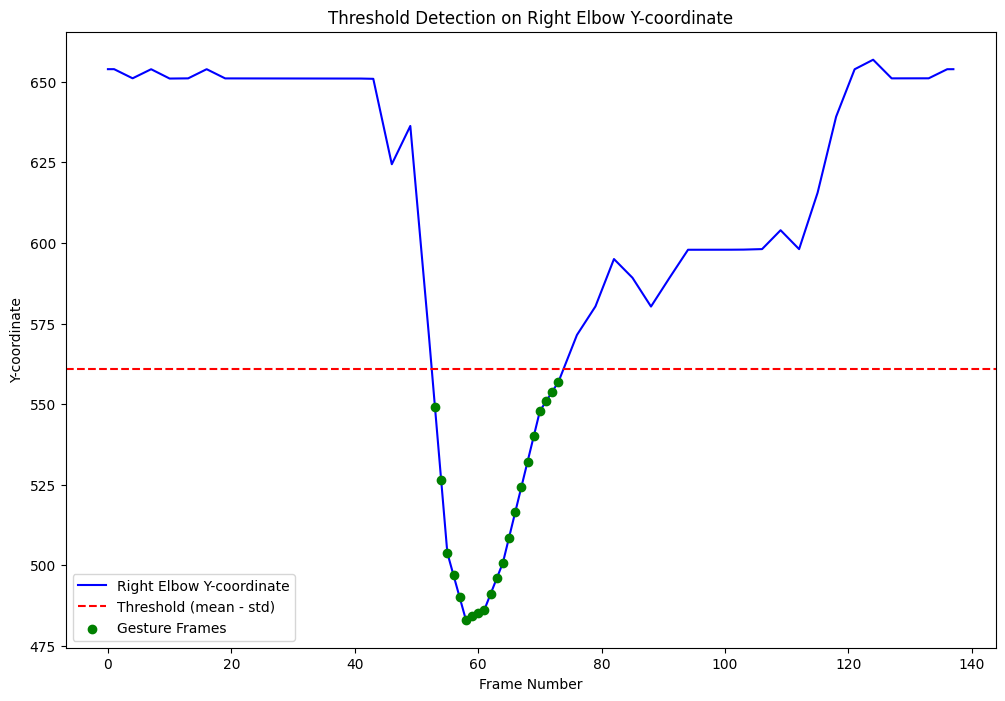

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def threshold_function(right_elbow_y):
    """
    Detect gesture frames based on the right elbow's Y-coordinate.
    Frames where the Y-coordinate is less than or equal to (mean - std) are considered as part of the gesture.
    
    Parameters:
        right_elbow_y (np.ndarray): 1D array of Y-coordinates of the right elbow over frames.
        
    Returns:
        list: A list of frame indices considered to be part of the gesture.
    """
    mean_value = np.mean(right_elbow_y)
    std_dev = np.std(right_elbow_y)
    threshold = mean_value - std_dev  # Our threshold: mean - std
    
    gesture_frames = []
    gesture_start = None
    gesture_end = None

    for i, y in enumerate(right_elbow_y):
        if y <= threshold:
            if gesture_start is None:
                gesture_start = i
            gesture_frames.append(i)
        elif gesture_start is not None:
            # If the gesture has started and this frame doesn't satisfy,
            # check if any future frames satisfy the threshold.
            future_satisfies = any(right_elbow_y[j] <= threshold for j in range(i+1, len(right_elbow_y)))
            if not future_satisfies:
                gesture_end = i - 1
                break

    if gesture_start is None:
        # No gesture detected
        return []
    if gesture_end is None:
        gesture_end = len(right_elbow_y) - 1

    return list(range(gesture_start, gesture_end + 1))


# --- Load one PKL file and visualize threshold detection ---

# Replace this with the path to one of your PKL files
pkl_file_path = r"/nas/Chingiz/sing_language/all_json_to_pkl/01_real_word_keypoint/01/01/NIA_SL_WORD0001_REAL01_F.pkl"

# Load the PKL file
with open(pkl_file_path, 'rb') as f:
    data = pickle.load(f)

# Extract the pose data
pose_data = data['pose']  # shape: (frames, keypoints, 3)
# Extract the right elbow Y-coordinate (assuming right elbow is at index 3 and Y is index 1)
right_elbow_y = pose_data[:, 3, 1]

# Get the frame indices that are detected as gesture frames
gesture_frames = threshold_function(right_elbow_y)

# Plot the right elbow Y-coordinate over frames
plt.figure(figsize=(12, 8))
plt.plot(right_elbow_y, label="Right Elbow Y-coordinate", color='blue')

# Plot the threshold line (mean - std)
threshold_line = np.mean(right_elbow_y) - np.std(right_elbow_y)
plt.axhline(threshold_line, color="red", linestyle="--", label="Threshold (mean - std)")

# Highlight the gesture frames
if gesture_frames:
    plt.scatter(gesture_frames, right_elbow_y[gesture_frames], color="green", label="Gesture Frames", zorder=5)
else:
    print("No gesture frames detected with the current threshold.")

plt.title("Threshold Detection on Right Elbow Y-coordinate")
plt.xlabel("Frame Number")
plt.ylabel("Y-coordinate")
plt.legend()
plt.show()
